In [ ]:
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ConfigSpace import (
    Categorical,
    Configuration,
    ConfigurationSpace,
    Constant,
    Float,
    InCondition,
    Integer,
)
from ConfigSpace.conditions import EqualsCondition, InCondition
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.svm import SVR
from smac import HyperparameterOptimizationFacade, Scenario
from xgboost import XGBRegressor
import xgboost as xgb

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message=".*algorithm did not converge.*")

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.2
plt.rcParams["grid.color"] = "#cccccc"
plt.rcParams["axes.xmargin"] = 0

PHASE1_DIR = Path(".")
PROCESSED_DIR = PHASE1_DIR / "processed"

In [ ]:
evaluations_df = pd.read_parquet(PROCESSED_DIR / "evaluations.parquet")
solvers_df = pd.read_parquet(PROCESSED_DIR / "solvers.parquet")
instances_df = pd.read_parquet(PROCESSED_DIR / "instances.parquet")

df = pd.merge(evaluations_df, solvers_df, left_on="solver_id", right_on="id").drop(columns=["id"])
df = pd.merge(df, instances_df, left_on="instance_id", right_on="id").drop(columns=["id"])
df

In [ ]:
# from sksurv.datasets import load_whas500
# from sksurv.linear_model import CoxPHSurvivalAnalysis
# from sksurv.ensemble import RandomSurvivalForest
# df_train

# cost = df_train["log_cost"].clip(upper=np.log(300 + 1)).to_numpy()
# is_censored = cost == np.log(300 + 1)

# y_train = np.zeros(len(cost), dtype=[('is_censored', bool), ('cost', float)])
# y_train['is_censored'] = is_censored
# y_train['cost'] = cost
# y_train

# model = RandomSurvivalForest()
# model.fit(X_train, y_train)
# surv_func = model.predict_survival_function(X_train)

## Functions

In [ ]:
def get_n_splits(df, n, instance_number, solver_number, random_state=0):
    """
    Generate indices to split data into training and test sets.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing solver evaluation data
    n : int
        Number of splits
    instance_number : int
        Number of instances to select
    solver_number : int
        Number of solver configurations to select
    random_state : int, default=0
        Random state for reproducibility
        
    Yields:
    -------
    train_idx : numpy.array
        Indices of training set
    test_idx : numpy.array
        Indices of test set
        
    Notes:
    ------
    1. Randomly selects solver_number solvers and instance_number instances from df
    2. Ensures that all evaluations from one solver are either in train or test set
    """
    rng = np.random.default_rng(random_state)
    
    if solver_number % n != 0:
        raise ValueError(f"solver_number ({solver_number}) must be divisible by n ({n})")
    
    all_solver_ids = df['solver_id'].unique()
    all_instance_ids = df['instance_id'].unique()
    
    if len(all_solver_ids) < solver_number:
        raise ValueError(f"Not enough solvers in df ({len(all_solver_ids)}) to select {solver_number}")
    
    if len(all_instance_ids) < instance_number:
        raise ValueError(f"Not enough instances in df ({len(all_instance_ids)}) to select {instance_number}")
    
    selected_solver_ids = rng.choice(all_solver_ids, size=solver_number, replace=False)
    selected_instance_ids = rng.choice(all_instance_ids, size=instance_number, replace=False)
    
    subset_df = df[
        df['solver_id'].isin(selected_solver_ids) & 
        df['instance_id'].isin(selected_instance_ids)
    ]
    
    expected_rows = solver_number * instance_number
    if len(subset_df) != expected_rows:
        raise ValueError(f"Incomplete data: Found {len(subset_df)} rows instead of expected {expected_rows}")
    
    solvers_per_fold = solver_number // n
    shuffled_solver_ids = rng.permutation(selected_solver_ids)
    
    for i in range(n):
        test_solvers = shuffled_solver_ids[i * solvers_per_fold:(i + 1) * solvers_per_fold]
        
        test_idx = subset_df[subset_df['solver_id'].isin(test_solvers)].index.values
        train_idx = subset_df[~subset_df['solver_id'].isin(test_solvers)].index.values
        
        total_samples = len(train_idx) + len(test_idx)
        if total_samples != expected_rows:
            raise ValueError(f"Total samples ({total_samples}) doesn't match expected number ({expected_rows})")
        
        yield train_idx, test_idx

In [ ]:
for train_idx, test_idx in get_n_splits(
    df,
    n=2,
    instance_number=10,
    solver_number=50,
    random_state=0,
):
    df_train = df.loc[train_idx]
    X_train = df_train.drop(columns=["solver_id", "instance_id", "generator", "cost", "log_cost"])
    y_train = df_train["log_cost"].clip(upper=np.log(1 + 1))

    df_test = df.loc[test_idx]
    X_test = df_test.drop(columns=["solver_id", "instance_id", "generator", "cost", "log_cost"])
    y_test = df_test["log_cost"]

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

In [32]:
def evaluate_model_with_cross_validation(
    df, 
    params, 
    n=5, 
    instance_number=10, 
    solver_number=1000, 
    random_state=0,
):
    result = {"rmse_values": [], "cc_values": [], "r2_values": []}
    all_y_test = []
    all_y_pred = []
    num_boost_round = params["num_boost_round"]
    del params["num_boost_round"]
    
    for train_idx, test_idx in get_n_splits(
        df,
        n=n,
        instance_number=instance_number,
        solver_number=solver_number,
        random_state=random_state,
    ):
        df_train = df.loc[train_idx]
        X_train = df_train.drop(columns=["solver_id", "instance_id", "generator", "cost", "log_cost"])
        y_train = df_train["log_cost"].clip(upper=np.log(1 + 1))

        df_test = df.loc[test_idx]
        X_test = df_test.drop(columns=["solver_id", "instance_id", "generator", "cost", "log_cost"])
        y_test = df_test["log_cost"]

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        dtrain = xgb.DMatrix(X_train)
        dtest = xgb.DMatrix(X_test)

        y_lower_bound = y_train
        y_upper_bound = np.where(y_train == np.log(1 + 1), np.inf, y_train)

        dtrain.set_float_info('label_lower_bound', y_lower_bound)
        dtrain.set_float_info('label_upper_bound', y_upper_bound)
        dtrain.set_label(y_lower_bound)

        bst = xgb.train(params, dtrain, num_boost_round=num_boost_round, evals=[(dtrain, 'train')], verbose_eval=False)

        y_pred = bst.predict(dtest)
        all_y_test.append(y_test.values)
        all_y_pred.append(y_pred)

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        if np.abs(np.std(y_test)) < 1e-3 or np.abs(np.std(y_pred)) < 1e-3:
            cc = np.nan
        else:
            cc, _ = pearsonr(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        result["rmse_values"].append(rmse)
        result["cc_values"].append(cc)
        result["r2_values"].append(r2)

    result["rmse"] = np.mean(result["rmse_values"])
    result["cc"] = np.mean(result["cc_values"])
    result["r2"] = np.mean(result["r2_values"])
    result["y_test"] = np.concatenate(all_y_test)
    result["y_pred"] = np.concatenate(all_y_pred)

    return result

In [33]:
def optimize_hyperparameters(
    configspace,
    df,
    n_trials=30,
    n=3,
    instance_number=10,
    solver_number=300,
    random_state=0,
):
    def train(config: Configuration, seed) -> float:            
        result = evaluate_model_with_cross_validation(
            df,
            dict(config),
            n=n,
            instance_number=instance_number,
            solver_number=solver_number,
            random_state=random_state,
        )
        return result["rmse"]

    scenario = Scenario(configspace, deterministic=True, n_trials=n_trials, seed=random_state)
    smac = HyperparameterOptimizationFacade(scenario, train, overwrite=True)
    return smac.optimize()

In [38]:
for train_idx, test_idx in get_n_splits(
    df,
    n=2,
    instance_number=10,
    solver_number=50,
    random_state=0,
):
    df_train = df.loc[train_idx]
    X_train = df_train.drop(columns=["solver_id", "instance_id", "generator", "cost", "log_cost"])
    y_train = df_train["log_cost"].clip(upper=np.log(1 + 1))

    df_test = df.loc[test_idx]
    X_test = df_test.drop(columns=["solver_id", "instance_id", "generator", "cost", "log_cost"])
    y_test = df_test["log_cost"]

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 1])

In [42]:
xgb_configspace = ConfigurationSpace(
    seed=0,
    space=[
        Constant(name="objective", value="survival:cox"),
        Constant(name="eval_metric", value="cox-nloglik"),
        Constant(name="n_estimators", value=100),
        Integer(name="max_depth", bounds=(2, 10), default=6),
        Float(name="learning_rate", bounds=(0.01, 0.3), default=0.1, log=True),
        Float(name="subsample", bounds=(0.5, 1.0), default=1.0),
        Float(name="colsample_bytree", bounds=(0.5, 1.0), default=1.0),
        Integer(name="min_child_weight", bounds=(1, 10), default=1),
        Float(name="gamma", bounds=(0, 5), default=0),
        Float(name="reg_lambda", bounds=(1e-3, 10.0), default=1e-3, log=True),
        Float(name="reg_alpha", bounds=(1e-3, 10.0), default=1e-3, log=True),
        Constant(name="seed", value=0),
    ],
)
params = dict(xgb_configspace.sample_configuration())
params

{'colsample_bytree': 0.7744067519637,
 'eval_metric': 'cox-nloglik',
 'gamma': 3.2294705653333,
 'learning_rate': 0.1477317633429,
 'max_depth': 6,
 'min_child_weight': 1,
 'n_estimators': 100,
 'objective': 'survival:cox',
 'reg_alpha': 0.0701321977995,
 'reg_lambda': 6.0072494759062,
 'seed': 0,
 'subsample': 0.7280751661083}

## Hyper-parameter optimization

In [34]:
N_TRIALS = 50
N = 2
INSTANCE_NUMBER = 10
SOLVER_NUMBER = 300
RANDOM_STATE = 0

### XGBoost

In [ ]:
xgb_configspace = ConfigurationSpace(
    seed=0,
    space=[
        Constant(name="objective", value="survival:cox"),
        Constant(name="eval_metric", value="cox-nloglik"),
        Constant(name="n_estimators", value=100),
        Integer(name="num_boost_round", bounds=(1, 300), default=100, log=True),
        Integer(name="max_depth", bounds=(2, 10), default=6),
        Float(name="learning_rate", bounds=(0.01, 0.3), default=0.1, log=True),
        Float(name="subsample", bounds=(0.5, 1.0), default=1.0),
        Float(name="colsample_bytree", bounds=(0.5, 1.0), default=1.0),
        Integer(name="min_child_weight", bounds=(1, 10), default=1),
        Float(name="gamma", bounds=(0, 5), default=0),
        Float(name="reg_lambda", bounds=(1e-3, 10.0), default=1e-3, log=True),
        Float(name="reg_alpha", bounds=(1e-3, 10.0), default=1e-3, log=True),
        Constant(name="seed", value=RANDOM_STATE),
    ],
)

xgb_incumbent = optimize_hyperparameters(
    configspace=xgb_configspace,
    df=df,
    n_trials=N_TRIALS,
    n=N,
    instance_number=INSTANCE_NUMBER,
    solver_number=SOLVER_NUMBER,
    random_state=RANDOM_STATE,
)
xgb_incumbent

[INFO][abstract_initial_design.py:95] Reducing the number of initial configurations from 130 to 12 (max_ratio == 0.25).
[INFO][abstract_initial_design.py:147] Using 12 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:306] Using only one seed for deterministic scenario.
[INFO][abstract_intensifier.py:516] Added config 4d6229 as new incumbent because there are no incumbents yet.
[INFO][smbo.py:320] Finished 50 trials.
[INFO][smbo.py:328] Configuration budget is exhausted:
[INFO][smbo.py:329] --- Remaining wallclock time: inf
[INFO][smbo.py:330] --- Remaining cpu time: inf
[INFO][smbo.py:331] --- Remaining trials: 0


Configuration(values={
  'colsample_bytree': 0.6334392605349,
  'eval_metric': 'cox-nloglik',
  'gamma': 3.1028234772384,
  'learning_rate': 0.0144145861178,
  'max_depth': 4,
  'min_child_weight': 9,
  'n_estimators': 100,
  'num_boost_round': 17,
  'objective': 'survival:cox',
  'reg_alpha': 6.9167496732409,
  'reg_lambda': 9.7078357604554,
  'seed': 0,
  'subsample': 0.8860676749609,
})

## Visual Comparison - total

In [36]:
result = evaluate_model_with_cross_validation(
    df,
    params=dict(xgb_incumbent),
    n=5,
    instance_number=10,
    solver_number=300,
    random_state=0,
)

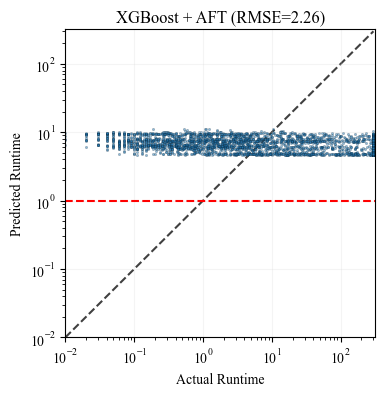

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

sc = ax.scatter(
    np.exp(result["y_test"]) - 1,
    np.exp(result["y_pred"]) - 1,
    alpha=0.5,
    edgecolors="k",
    lw=0.2,
    s=3,
)
ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlim(0.01, 320)
ax.set_ylim(0.01, 320)
ax.plot([0.01, 300], [0.01, 300], "k--", alpha=0.75, zorder=0)
ax.set_title(f'XGBoost + AFT (RMSE={result["rmse"]:.2f})')
ax.axhline(y=1, color='red', linestyle='--')

ax.set_ylabel("Predicted Runtime")
ax.set_xlabel("Actual Runtime")
plt.savefig("xgboost_aft.png", dpi=300, bbox_inches="tight")
plt.show()